### Evaluating PPO in CityLearn

Import packages

In [1]:
# packages
import os
import time
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import joblib
from ipywidgets import IntProgress
from typing import List

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper

# baseline RL algorithms
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# helper functions
from kpi_utils import get_kpis, plot_building_kpis, plot_district_kpis
from kpi_utils import plot_building_load_profiles, plot_district_load_profiles, plot_battery_soc_profiles, plot_simulation_summary
from env_utils import set_n_buildings_2022
from obs_utils import get_n_observations
from rlc_utils import CustomReward

2025-04-07 15:34:27.555934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744054467.579274 3503767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744054467.586551 3503767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744054467.606820 3503767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744054467.606861 3503767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744054467.606864 3503767 computation_placer.cc:177] computation placer alr

Load data from CityLearn 2022 Challenge. 

The CityLearn Challenge 2022 focuses on the opportunity brought on by home battery storage devices and photovoltaics. It leverages CityLearn, a Gym Environment, for building distributed energy resource management and demand response. The challenge utilizes 1 year of operational electricity demand and PV generation data from 17 single-family buildings in the Sierra Crest home development in Fontana, California, that were studied for Grid integration of zero net energy communities.

Participants will develop energy management agent(s) and their reward function for battery charge and discharge control in each building to minimise the monetary cost of electricity drawn from the grid and the CO2 emissions when electricity demand is satisfied by the grid.

In [2]:
data_dir = '/home/jt9744/projects/thesis/CityLearn_thesis/data/datasets'
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
ds = DataSet()
schema = ds.get_schema(DATASET_NAME)

Data Preprocessing:
1. Use 2, 4, or 8 buildings to measure scalability (consider using 12 and 15 if there's enough time)
2. Use centralized control

These can be modified directly in the schema. The buildings will be pseudo-randomly selected with a seed for reproducibility. 

In [3]:
n_buildings = 8 # 2, 4, or 8 
schema, buildings = set_n_buildings_2022(schema, n_buildings)
print('Number of buildings:', n_buildings)
print('Selected buildings:', buildings)
print(f'Number of observations: {get_n_observations(n_buildings)}')
# use centralized control
schema['central_agent'] = True

Number of buildings: 8
Selected buildings: ['Building_2', 'Building_5', 'Building_6', 'Building_7', 'Building_8', 'Building_10', 'Building_13', 'Building_16']
Number of observations: 56


#### Implementing PPO 

In [4]:
# logging
log_dir = f"./sb3_logs/ppo/{n_buildings}_buildings" # Directory for Monitor logs and TensorBoard logs
os.makedirs(log_dir, exist_ok=True)
ppo_model = PPO.load(os.path.join(log_dir, f"ppo_model_{n_buildings}_buildings"), device='cpu')

#### Evaluating PPO 

In [5]:
eval_env = CityLearnEnv(schema)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
observations, info = eval_env.reset()

In [ ]:
ppo_actions_list = []
rewards = []
terminated, truncated = False, False

start_time = time.time()
while not (terminated or truncated):
    actions, _ = ppo_model.predict(observations, deterministic=True)
    observations, reward, terminated, truncated, info = eval_env.step(actions)
    ppo_actions_list.append(actions)
    rewards.append(reward)
print(f"Total time taken for evaluation: {(time.time()-start_time) / 60:.2f} minutes")
rewards = [r[0].item() if type(r[0]) == np.float32 else r[0] for r in rewards]
rewards = [r.item() if type(r) == np.float32 else r for r in rewards]
ppo_actions_list = np.stack(ppo_actions_list)

In [10]:
performance = eval_env.unwrapped.evaluate()

# filter KPIs
kpis = {'all_time_peak_average': 'Average peak cost.',
        'carbon_emissions_total': 'Rolling sum of carbon emissions.', 
        'cost_total': 'Rolling sum of electricity monetary cost.',
        'daily_one_minus_load_factor_average': 'A measure of load variability / peakiness (daily average).', 
        'daily_peak_average': 'Average daily peak cost.',
        'electricity_consumption_total': 'Rolling sum of positive electricity consumption.',
        'monthly_one_minus_load_factor_average': 'A measure of load variability / peakiness (monthly average).',
        'ramping_average': 'Average rolling sum of absolute difference in net electric consumption between consecutive time steps',
        'zero_net_energy': 'Rolling sum of net electricity consumption'}
performance = performance[performance['cost_function'].isin(kpis.keys())].reset_index(drop=True)

# save evaluation
results_dir = f'results/results_ppo_2022_centralized/{n_buildings}_buildings'
os.makedirs(results_dir, exist_ok=True)
print(f"\nSaving results to {results_dir}...")
joblib.dump(rewards, os.path.join(results_dir, 'rewards.joblib'))
joblib.dump(ppo_actions_list, os.path.join(results_dir, 'total_actions.joblib'))
performance.to_csv(os.path.join(results_dir, 'performance_kpis.csv'), index=False)
with open(f'{results_dir}/kpi_metadata', "w") as f:
    json.dump(kpis, f, indent=4)
    
# view evaluation
performance


Saving results to results/results_ppo_2022_centralized/8_buildings...


,cost_function,value,name,level
0,all_time_peak_average,0.933263,District,district
1,carbon_emissions_total,0.986335,District,district
2,cost_total,0.958007,District,district
3,daily_one_minus_load_factor_average,0.978242,District,district
4,daily_peak_average,0.904017,District,district
5,electricity_consumption_total,0.989556,District,district
6,monthly_one_minus_load_factor_average,0.984670,District,district
7,ramping_average,0.975114,District,district
8,zero_net_energy,1.034420,District,district
9,electricity_consumption_total,1.001205,Building_2,building


In [11]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

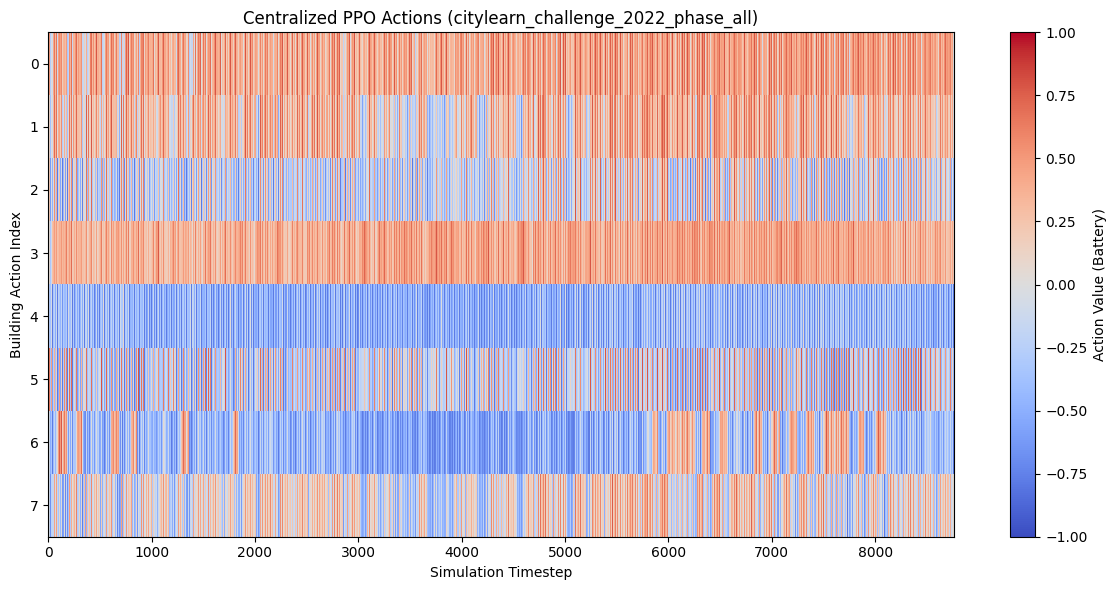

In [12]:
# Plot actions performance
plt.figure(figsize=(12, 6))
# Transpose for plotting: actions on y-axis, time on x-axis
plt.imshow(ppo_actions_list.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'))
plt.show() 

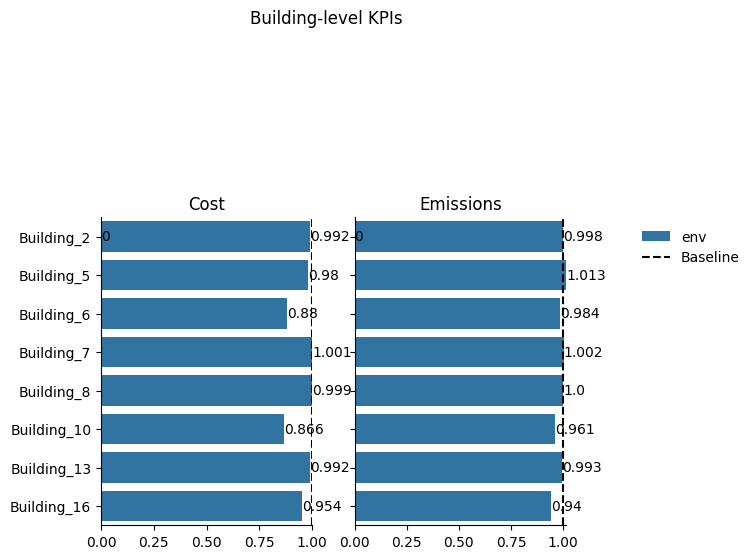

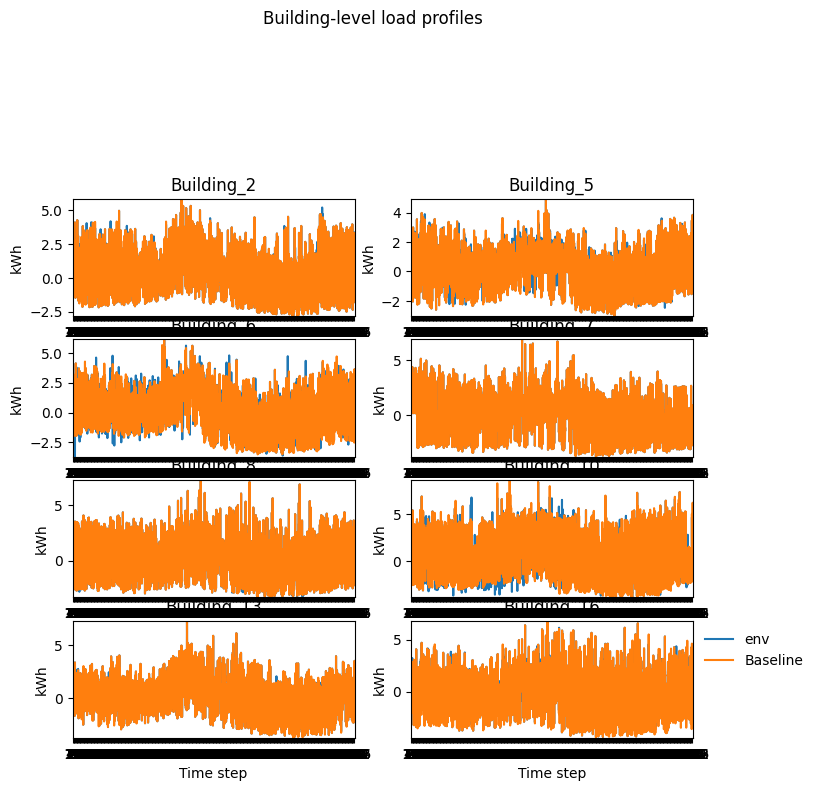

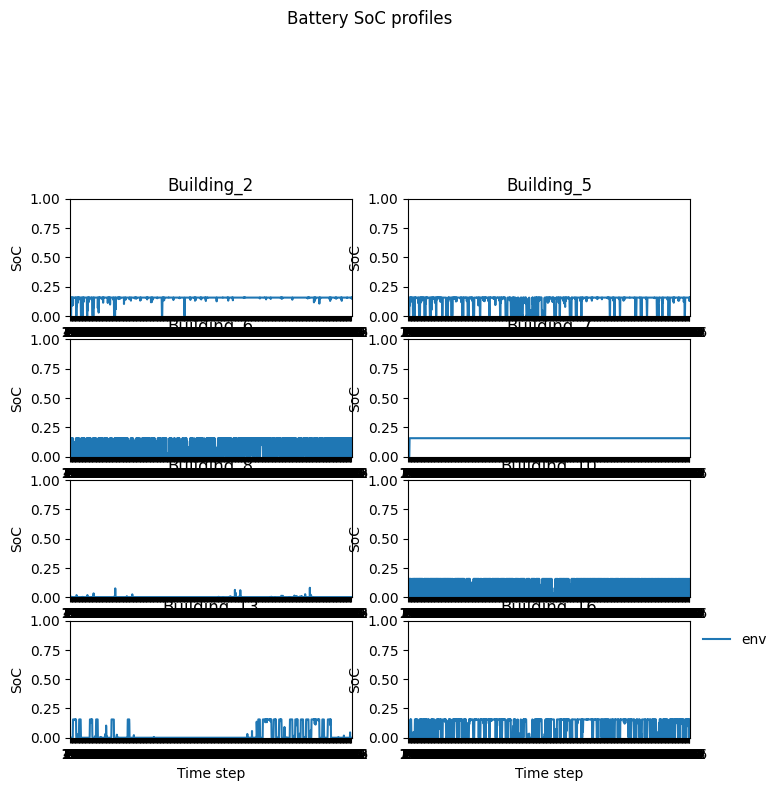

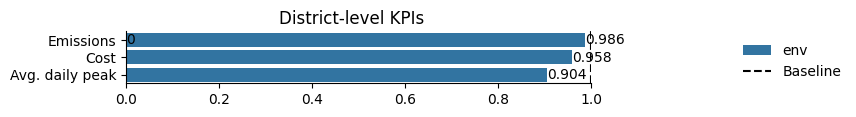

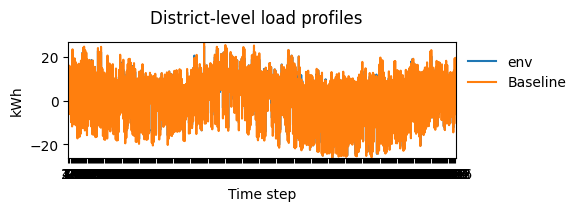

In [13]:
plots = plot_simulation_summary({'env': eval_env.unwrapped}, ret=True)
for plot_name in plots:
    plots[plot_name].savefig(f'{results_dir}/{plot_name}')

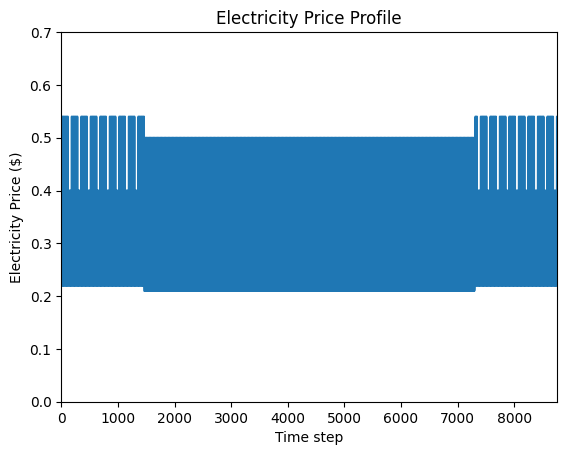

In [14]:
plt.plot(eval_env.unwrapped.buildings[0].pricing.electricity_pricing)
plt.ylim(0,0.7)
plt.ylabel('Electricity Price ($)')
plt.xlabel('Time step')
plt.title('Electricity Price Profile')
plt.savefig(os.path.join(results_dir, 'electricity_price.png'))

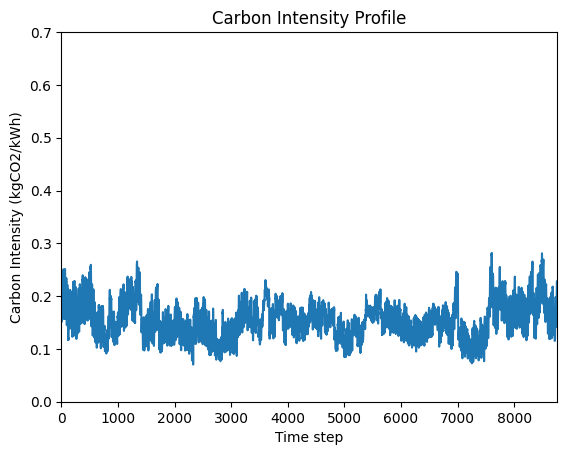

In [15]:
plt.plot(eval_env.unwrapped.buildings[0].carbon_intensity.carbon_intensity)
plt.ylim(0,0.7)
plt.ylabel('Carbon Intensity (kgCO2/kWh)')
plt.xlabel('Time step')
plt.title('Carbon Intensity Profile')
plt.savefig(os.path.join(results_dir, 'carbon_intensity.png'))